# Machine Translation using byte pair encoding

### Introduction
In this notebook, we will see how to create a language translation model which is an application of neural machine translation. We will be using the packages from keras at first and we will also test the same model and dataset with Byte-pair encoding for better results. 



## Loading the Data

Out first objective for this is to load the libraries and get the required data. For this project we have a french text file and an english text document each having 137860 sentences. In language translation projects this can be considered as a moderately sized data as we find models with very large data. We are currently using GPU provided by Google Colab.

In [16]:
import re, collections

import helper
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, SGD
from keras.losses import sparse_categorical_crossentropy
from sklearn.model_selection import train_test_split
from keras.regularizers import L1L2

### Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [17]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4001446454133006743
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 608189705821413393
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


### Load Data

All the data can be found in the same github repository. We first load the data from our text files into english_sentences and french_sentences sentences respectively by reading each line of the text file by cleaning the line. We have found a preprocessed clean dataset we just need to do small changes to it like removing the unnecessary trailing spaces, converting the text to lower case and removing punctuation to create better bag of vocabulary.

In [18]:
# Load English data
eng_file = 'English_data.txt'
fre_file = 'French_data.txt'
english_sentences = []
max_len = 0
with open(eng_file) as f:
    for line in f:
      if len(line) > max_len:
        max_len = len(line)
      line = line.rstrip()
      line = line.lower()
      line = re.sub(r'[^\w\s]', '', line)
      english_sentences.append(line)
# Load French data
french_sentences = []
with open(fre_file) as f:
    for line in f:
      if len(line) > max_len:
        max_len = len(line)
      line = line.rstrip()
      line = line.lower()
      line = re.sub(r'[^\w\s]', '', line)
      french_sentences.append(line)
print('Dataset Loaded')

Dataset Loaded


### Sample english and french data in our dataset

In [19]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn  and it is snowy in april 
small_vocab_fr Line 1:  new jersey est parfois calme pendant l automne  et il est neigeux en avril 
small_vocab_en Line 2:  the united states is usually chilly during july  and it is usually freezing in november 
small_vocab_fr Line 2:  les étatsunis est généralement froid en juillet  et il gèle habituellement en novembre 


## Tokenize From Keras

Tokens are the building blocks of Natural Language. In order to get our computer to understand any text, we need to break that word down in a way that our machine can understand. Tokenization is a way of separating a piece of text into smaller units called tokens. Tokenization can be broadly classified into 3 types – word, character, and subword tokenization. 

Keras offers a library for word tokenization which can be used to create a bag of words which has all the words present in the dataset. 

In [20]:
def tokenize(x):

    # Create the tokeninzer
    t = Tokenizer()
    # Create dictionary mapping words (str) to their rank/index (int)
    t.fit_on_texts(x)
    # Use the tokenizer to tokenize the text
    text_sequences = t.texts_to_sequences(x)
    return text_sequences, t

## Padding

All the neural networks require to have inputs that have the same shape and size. But, we can't expect all the sentences to be of the same length. So, we use padding. Padding is the process of adding the zeros to the sequence to make all the samples in the same size.  

We import pad_sequences from keras.preprocessing.sequence

In [21]:
def pad(x, length=None):
    
    # If length equals None, set it to be the length of the longest sequence in x
    if length == None:
        length = len(max(x, key=len))
        
    # Use Keras's pad_sequences to pad the sequences with 0's
    padded_sequences = pad_sequences(sequences=x, maxlen=length, padding='post', value=0)
    
    return padded_sequences

## Data Pre-processing of input data

RNN models wont accept text as input they olnly take sequences of integers. So, we'll convert the text into sequences of integers using the following preprocess methods:

1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

In [22]:
def preprocess(x, y):

    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk
    
english_sentences_train, english_sentences_test, french_sentences_train, french_sentences_test =\
    train_test_split(english_sentences, french_sentences, test_size=0.2, random_state=42)

preproc_english_sentences_train, preproc_french_sentences_train, english_tokenizer_train, french_tokenizer_train =\
    preprocess(english_sentences_train, french_sentences_train)
    
max_english_sequence_length_train = preproc_english_sentences_train.shape[1]
max_french_sequence_length_train = preproc_french_sentences_train.shape[1]
english_vocab_size_train = len(english_tokenizer_train.word_index)
french_vocab_size_train = len(french_tokenizer_train.word_index)

### Tokeniztion of unknown sentences

The below code displays how the sentence which is not used for tokenization i is tokenized into a sequence of integers. If you observe, some of the lists are empty. It is because of a problem called Out of Vocabulary (OOV). Out-of-vocabulary (OOV) are terms that are not part of the tokenized words found in a natural language processing environment.

In [23]:
Unknown_sentence = 'he dislikes grapefruit limes and lemons'
Tok_data = tokenize(Unknown_sentence)
print(Tok_data)
## All the empty values represent Unknown data

([[10], [1], [], [5], [2], [3], [4], [2], [11], [1], [3], [], [12], [6], [7], [13], [1], [14], [6], [15], [2], [16], [], [4], [2], [8], [1], [3], [], [7], [9], [5], [], [4], [1], [8], [17], [9], [3]], <keras_preprocessing.text.Tokenizer object at 0x7fad4fcf7910>)


## Byte-Pair Encoding

Byte-Pair Encoding aims to reduce the Out of Vocabulary words in a model with limited words in the dictionary by trying to combine word and character tokenization techniques. For example, if the model learned the relationship between "old", "older", and "oldest" then it could easily translate the word "smarter" or "smartest" if the dictionary has the word "smart" in it. A similar method can be used for a lot of words like words ending with "ing" (eat, eating), "ed" (learn, learned). We still can't tokenize for some words but it can tokenize more words than word-tokenization can which can be shown by using both the tokenizations on the same RNN model.

The steps needed for BPE are

1. Initialize vocabulary.
2. Represent each word as a combination of the characters along with the special end of word token </w>.
3. Iteratively count character pairs in all tokens of the vocabulary.
4. Merge every occurrence of the most frequent pair, add the new character n-gram to the vocabulary.


In [24]:
# Byte-Pair Encoding algorithm
def tokenize_bpe(filename):
  def get_vocab(filename):
    # Creates a vocab from file
    # Splits the word, removes punctuation, makes it lower case and adds </w> at the end
    vocab = collections.defaultdict(int)
    with open(filename) as f:
        for line in f:
            line = re.sub(r'[^\w\s]', '', line)
            line = line.lower()
            words = line.strip().split()
            for word in words:
                vocab[' '.join(list(word)) + ' </w>'] += 1

    return vocab

  def get_stats(vocab):
      pairs = collections.defaultdict(int)
      for word, freq in vocab.items():
          symbols = word.split()
          for i in range(len(symbols)-1):
              pairs[symbols[i],symbols[i+1]] += freq
      return pairs

  def merge_vocab(pair, v_in):
      v_out = {}
      bigram = re.escape(' '.join(pair))
      p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
      for word in v_in:
          w_out = p.sub(''.join(pair), word)
          v_out[w_out] = v_in[word]
      return v_out

  def get_tokens_from_vocab(vocab):
      tokens_frequencies = collections.defaultdict(int)
      vocab_tokenization = {}
      for word, freq in vocab.items():
          word_tokens = word.split()
          for token in word_tokens:
              tokens_frequencies[token] += freq
          vocab_tokenization[''.join(word_tokens)] = word_tokens
      return tokens_frequencies, vocab_tokenization

  def measure_token_length(token):
      if token[-4:] == '</w>':
          return len(token[:-4]) + 1
      else:
          return len(token)

  vocab = get_vocab(filename)
  tokens_frequencies, vocab_tokenization = get_tokens_from_vocab(vocab)

  num_merges = 10000
  for i in range(num_merges):
      pairs = get_stats(vocab)
      if not pairs:
          break
      best = max(pairs, key=pairs.get)
      vocab = merge_vocab(best, vocab)
      #print('Iter: {}'.format(i))
      #print('Best pair: {}'.format(best))
      tokens_frequencies, vocab_tokenization = get_tokens_from_vocab(vocab)
  return(tokens_frequencies, vocab_tokenization)
def tokenize_word(string, sorted_tokens, unknown_token='</u>'):
      
    if string == '':
        return []
    if sorted_tokens == []:
        return [unknown_token]

    string_tokens = []
    for i in range(len(sorted_tokens)):
        token = sorted_tokens[i]
        #token_reg = re.escape(token.replace('.', '[.]'))

        matched_positions = [(m.start(0), m.end(0)) for m in re.finditer(token, string)]
        if len(matched_positions) == 0:
            continue
        substring_end_positions = [matched_position[0] for matched_position in matched_positions]

        substring_start_position = 0
        for substring_end_position in substring_end_positions:
            substring = string[substring_start_position:substring_end_position]
            string_tokens += tokenize_word(string=substring, sorted_tokens=sorted_tokens[i+1:], unknown_token=unknown_token)
            string_tokens += [token]
            substring_start_position = substring_end_position + len(token)
        remaining_substring = string[substring_start_position:]
        string_tokens += tokenize_word(string=remaining_substring, sorted_tokens=sorted_tokens[i+1:], unknown_token=unknown_token)
        break
    return string_tokens
def get_idx(x,sorted_tokens):
  a = []
  for i in x:
    b = []
    for j in i.split():
      j = j+'</w>'
      if j in sorted_tokens:
        b.append(sorted_tokens[j])
      else:
        temp = tokenize_word(string=j, sorted_tokens=list(sorted_tokens.keys()), unknown_token='</u>')
        if temp:
          b.append(temp)
        else:
          b.append(0)
    a.append(b)
  return(a,list(sorted_tokens.keys()))

### Tokenizing input data

Here we tokenize the input french and English sentences using Byte Pair Encoding. Here we are taking the number of merges as 10000, this is a hyper-parameter we set as per our data. As mentioned earlier, we append each word by '</w>'. This helps to recognize the end of words as the sentences are divided into letters before checking for pairs and '</w>' is used as the end of a word phrase. We also create a dictionary of words with indices.

In [25]:
tokens_frequencies_en, vocab_tokenization_en = tokenize_bpe(eng_file)
tokens_frequencies_fr, vocab_tokenization_fr = tokenize_bpe(fre_file)
k = 1
for i in vocab_tokenization_en:
  vocab_tokenization_en[i] = k
  k += 1
k = 1
for i in vocab_tokenization_fr:
  vocab_tokenization_fr[i] = k
  k += 1

### Tokeniztion of unknown sentences

The below code displays how the sentence which is not used for tokenization is tokenized into a sequence of integers using Byte pair encoding.

In [26]:
text_sentences = [
    'new jersey is sometimes quiet during autumn and it is snowy in april',
    'he liked grapefruit limes and lemons']
text_tokenized, text_tokenizer = get_idx(text_sentences,vocab_tokenization_en)
print(text_tokenizer)
print(text_tokenized)

['new</w>', 'jersey</w>', 'is</w>', 'sometimes</w>', 'quiet</w>', 'during</w>', 'autumn</w>', 'and</w>', 'it</w>', 'snowy</w>', 'in</w>', 'april</w>', 'the</w>', 'united</w>', 'states</w>', 'usually</w>', 'chilly</w>', 'july</w>', 'freezing</w>', 'november</w>', 'california</w>', 'march</w>', 'hot</w>', 'june</w>', 'mild</w>', 'cold</w>', 'september</w>', 'your</w>', 'least</w>', 'liked</w>', 'fruit</w>', 'grape</w>', 'but</w>', 'my</w>', 'apple</w>', 'his</w>', 'favorite</w>', 'orange</w>', 'paris</w>', 'relaxing</w>', 'december</w>', 'busy</w>', 'spring</w>', 'never</w>', 'our</w>', 'lemon</w>', 'january</w>', 'warm</w>', 'lime</w>', 'her</w>', 'banana</w>', 'he</w>', 'saw</w>', 'a</w>', 'old</w>', 'yellow</w>', 'truck</w>', 'india</w>', 'rainy</w>', 'that</w>', 'cat</w>', 'was</w>', 'most</w>', 'loved</w>', 'animal</w>', 'dislikes</w>', 'grapefruit</w>', 'limes</w>', 'lemons</w>', 'february</w>', 'china</w>', 'pleasant</w>', 'october</w>', 'wonderful</w>', 'nice</w>', 'summer</w>', 

### Data preprocessing using BPE

In [27]:
def preprocess_BPE(english_sentences, french_sentences):
  preprocess_x, x_tk = get_idx(english_sentences,vocab_tokenization_en)
  preprocess_y, y_tk = get_idx(french_sentences,vocab_tokenization_fr)

  preprocess_x = pad_sequences(preprocess_x,maxlen=max_len,padding='post')
  preprocess_y = pad_sequences(preprocess_y,maxlen=max_len,padding='post')
  preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
  return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences_bpe, preproc_french_sentences_bpe, english_tokenizer_bpe, french_tokenizer_bpe=preprocess_BPE(english_sentences_train, french_sentences_train)
english_vocab_size_bpe = len(english_tokenizer_bpe)
french_vocab_size_bpe = len(french_tokenizer_bpe)

## Models
This sectionis to demonstrate word tokenization and byte pair encoding for two models

- Model 1 is a simple RNN (Word tokenization, BPE)
- Model 2 is a RNN with Embedding (BPE)


### Ids Back to Text

The neural network will be translating the input to a sequence of unreadable numbers, which isn't the final form we want. We want the translated french sentences.  The function 'logits_to_text' will convert the output integer sequences from the neural network to the French words.

In [28]:
def logits_to_text(logits, tokenizer):


    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### RNN Models

A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
 

In [29]:
def embed_model_split(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):

    # RNN model with embedding layer
    input_layer = Input(shape=input_shape[1:])
    embedding_layer = Embedding(512, english_vocab_size)(input_layer)
    x = GRU(512, return_sequences=True)(embedding_layer)
    x = TimeDistributed(Dense(french_vocab_size*4, activation='relu'))(x)
    output_layer = Dense(french_vocab_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    learning_rate = 0.01
    opt = Adam(learning_rate=learning_rate)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

# Pad the input 
tmp_x = pad(preproc_english_sentences_train, preproc_french_sentences_train.shape[1])

# Train the neural network on the training data
embedding_model_split_train = embed_model_split(tmp_x.shape,
                                  max_french_sequence_length_train,
                                  english_vocab_size_train + 1,
                                  french_vocab_size_train + 1)

hist = embedding_model_split_train.fit(tmp_x, preproc_french_sentences_train, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(embedding_model_split_train.predict(tmp_x[:1])[0], french_tokenizer_train))

Epoch 1/10
87/87 [==============================] - 32s 114ms/step - loss: 3.8145 - accuracy: 0.5129 - val_loss: 0.6742 - val_accuracy: 0.7976
Epoch 2/10
87/87 [==============================] - 9s 107ms/step - loss: 0.5613 - accuracy: 0.8251 - val_loss: 0.3966 - val_accuracy: 0.8666
Epoch 3/10
87/87 [==============================] - 9s 109ms/step - loss: 0.3684 - accuracy: 0.8759 - val_loss: 0.3244 - val_accuracy: 0.8900
Epoch 4/10
87/87 [==============================] - 10s 110ms/step - loss: 0.3005 - accuracy: 0.8973 - val_loss: 0.2776 - val_accuracy: 0.9044
Epoch 5/10
87/87 [==============================] - 10s 112ms/step - loss: 0.2606 - accuracy: 0.9097 - val_loss: 0.2645 - val_accuracy: 0.9090
Epoch 6/10
87/87 [==============================] - 10s 113ms/step - loss: 0.2446 - accuracy: 0.9145 - val_loss: 0.2568 - val_accuracy: 0.9110
Epoch 7/10
87/87 [==============================] - 10s 112ms/step - loss: 0.2371 - accuracy: 0.9167 - val_loss: 0.2489 - val_accuracy: 0.9150
E

### Ids Back to Text BPE

Here we use a similar logits_to_text function to convert the output integer sequences from the neural network to the French words. Since, we used different tokenization methods we had to change the function a bit.

In [30]:
def logits_to_text_bpe(logits, index_to_words):

    index_to_words = {v: k for k, v in index_to_words.items()}
    index_to_words[0] = '<PAD>'
    
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

### RNN for BPE

We use the same model for BPE as well. So, we can  check the accuracy and compare the results. 

In [36]:
preproc_english_sentences_bpe, preproc_french_sentences_bpe, english_tokenizer_bpe, french_tokenizer_bpe=preprocess_BPE(english_sentences_test, french_sentences_test)

tmp_x = preproc_english_sentences_bpe.reshape((-1, preproc_french_sentences_bpe.shape[-2]))

embedding_model_split_train = embed_model_split(tmp_x.shape,
                                  max_french_sequence_length_train,
                                  english_vocab_size_train + 1,
                                  french_vocab_size_train + 1)

hist_bpe = embedding_model_split_train.fit(tmp_x, preproc_french_sentences_bpe, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print(logits_to_text_bpe(embedding_model_split_train.predict(tmp_x[:1])[0], vocab_tokenization_fr))

Epoch 1/10
22/22 [==============================] - 15s 608ms/step - loss: 6.7716 - accuracy: 0.6179 - val_loss: nan - val_accuracy: 0.8936
Epoch 2/10
22/22 [==============================] - 13s 608ms/step - loss: 2.5988 - accuracy: 0.8911 - val_loss: nan - val_accuracy: 0.8972
Epoch 3/10
22/22 [==============================] - 13s 614ms/step - loss: 0.8403 - accuracy: 0.8984 - val_loss: nan - val_accuracy: 0.9015
Epoch 4/10
22/22 [==============================] - 13s 604ms/step - loss: 0.5749 - accuracy: 0.9041 - val_loss: nan - val_accuracy: 0.9055
Epoch 5/10
22/22 [==============================] - 13s 596ms/step - loss: 0.4518 - accuracy: 0.9070 - val_loss: nan - val_accuracy: 0.9142
Epoch 6/10
22/22 [==============================] - 13s 592ms/step - loss: 0.3955 - accuracy: 0.9152 - val_loss: nan - val_accuracy: 0.9172
Epoch 7/10
22/22 [==============================] - 13s 593ms/step - loss: 0.3771 - accuracy: 0.9179 - val_loss: nan - val_accuracy: 0.9187
Epoch 8/10
22/22 [==

### Accuracy 

Here we compare the accuracy of both models and we can clearly see that the accuracy of model using byte pair encoding is higher than word tokenized model.

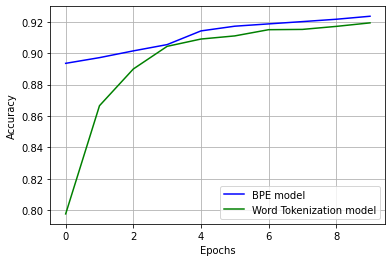

In [37]:
acc = hist.history['val_accuracy']
acc_bpe = hist_bpe.history['val_accuracy']
epochs = range(1,10)
plt.plot(acc_bpe, 'b', label='BPE model')
plt.plot(acc, 'g', label='Word Tokenization model')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### RNN with Embedding

Small changes to the model can increase the accuracy

    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained


In [34]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):

    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(256, return_sequences=True))    
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

#test_embed_model(embed_model)

# TODO: Reshape the input
tmp_x = preproc_english_sentences_bpe.reshape((-1, preproc_french_sentences_bpe.shape[-2]))

# TODO: Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences_bpe.shape[1],
    english_vocab_size_bpe+1,
    french_vocab_size_bpe+1)

embed_rnn_model.summary()

embed_rnn_model.fit(tmp_x, preproc_french_sentences_bpe, batch_size=1024, epochs=10, validation_split=0.2)

# TODO: Print prediction(s)
print(logits_to_text_bpe(embed_rnn_model.predict(tmp_x[:1])[0], vocab_tokenization_fr))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 115, 256)          51200     
_________________________________________________________________
gru_3 (GRU)                  (None, 115, 256)          394752    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 115, 1024)         263168    
_________________________________________________________________
dropout (Dropout)            (None, 115, 1024)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 115, 345)          353625    
Total params: 1,062,745
Trainable params: 1,062,745
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
22/22 [==============================] - 10s 366ms/step - loss: 2.0656 - accuracy: 0.7511 - val_loss:

### Test the model on the test data set

See how the model trained on the training set data performs on the unseen test data.

In [35]:
preproc_english_sentences_bpe, preproc_french_sentences_bpe, english_tokenizer_bpe, french_tokenizer_bpe=preprocess_BPE(english_sentences_test, french_sentences_test)

test_x = preproc_english_sentences_bpe.reshape((-1, preproc_french_sentences_bpe.shape[-2]))

embedding_model_score = embed_rnn_model.evaluate(test_x, preproc_french_sentences_bpe, verbose=0)

print("Embedding model accuracy on unseen test data: {0:.2f}%".format(embedding_model_score[1]*100))

Embedding model accuracy on unseen test data: 97.29%


##Enhancements

This project focuses on using Byte-Pair encoding, we can use this tokenization method with different network architectures for machine translation and evaluate the models according to best practices by splitting the data into separate test & training sets. Every requirement is different, based on it we can adjust the network architecture and hyperparameters before finalizing the model.